<a href="https://colab.research.google.com/github/JpChii/nlp-with-hugging-face/blob/main/notebooks/4-multilingual-named-entity-recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multilingual Named Entity Recognition

In the series of notebooks till now, we've applied transformers to solve NLP problems on engligh corpora. What if the dataset has multiple languages, mainitainig multiple monolingual models in production will not be any fun.

Fortunatley, we've a class of multilingual transformer to the rescue. Like BERT they are pretrained for masked language modeling as a pretraining objective.

By pretraining on a huge multilingual corpora, we can achieve zero-shot cross lingual transfer. By fine tuning the pretrained label on one language, we can evaluate it on another language without fine tuning for that language explictly.

In this notebook we'll use XLM-RoBERTa pretrained on [2.5Terabyte of text based on Common Crawl Corpus](https://commoncrawl.org/).
The dataset contains only data without parallel texts(translations) and trained an encoder with MLM on this dataset.

Some applications of NER:
* insights from documents
* augmenting quality of search engines
* building a strucutred database from corpus

> Note: *Zero-short transfer or zero-shot learning* usually refers to the task of training a model on one set of labels and then evaluating it on a different set of labels. In the context of transformers, zero-shot learning may also refer to situations where a lnaguage model like GPT-3 is evaluated ona downstream task that it wasn't even fine tuned on.

Problem(assumption):

We want to perfoerm NER for a customer based in Switzerlang, where there are four national languages(With English serving as bridge between them.)

## The Dataset.

We'll use subset of Cross-lingual TRansfer Evaluation of Multilingual Encoder(XTREME) benchmark called WikiANN or PAN-X. This dataset consisits of Wikipedia articles in many languages, including four languages from our Problem. Each article is annotated with `LOC`(location), `PER`(person) and `ORG`(organisation) tags in [IOB2 fornat](https://oreil.ly/yXMUn)

In this format, a `B0` prefix indicates beginning of an entity and consecutive tokens belonging to the same entity are given `I-` prefix. `O` tag indicate that the token does not belong to any entity.

In [1]:
!pip install -r requirements.txt -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.3/298.3 kB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 12.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.2/156.2 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.1/405.1 kB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Sample of the annotation scheme
import pandas as pd
toks = "Jeff Dean is a computer scientist at Google in California".split()
lbls = ["B-PER", "I-PER", "O", "O", "O", "O", "O", "B-ORG", "O", "B-LOC"]
df = pd.DataFrame(data=[toks, lbls], index=['Tokens', 'Tags'])
df

,0,1,2,3,4,5,6,7,8,9
Tokens,Jeff,Dean,is,a,computer,scientist,at,Google,in,California
Tags,B-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC


In [3]:
from datasets import get_dataset_config_names

xtreme_subsets = get_dataset_config_names("xtreme")
print(f"Number of subsets in XTREME {len(xtreme_subsets)}")
print(f"Subset names in XTREME {xtreme_subsets}")

Downloading:   0%|          | 0.00/9.04k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/23.1k [00:00<?, ?B/s]

Number of subsets in XTREME 183
Subset names in XTREME ['XNLI', 'tydiqa', 'SQuAD', 'PAN-X.af', 'PAN-X.ar', 'PAN-X.bg', 'PAN-X.bn', 'PAN-X.de', 'PAN-X.el', 'PAN-X.en', 'PAN-X.es', 'PAN-X.et', 'PAN-X.eu', 'PAN-X.fa', 'PAN-X.fi', 'PAN-X.fr', 'PAN-X.he', 'PAN-X.hi', 'PAN-X.hu', 'PAN-X.id', 'PAN-X.it', 'PAN-X.ja', 'PAN-X.jv', 'PAN-X.ka', 'PAN-X.kk', 'PAN-X.ko', 'PAN-X.ml', 'PAN-X.mr', 'PAN-X.ms', 'PAN-X.my', 'PAN-X.nl', 'PAN-X.pt', 'PAN-X.ru', 'PAN-X.sw', 'PAN-X.ta', 'PAN-X.te', 'PAN-X.th', 'PAN-X.tl', 'PAN-X.tr', 'PAN-X.ur', 'PAN-X.vi', 'PAN-X.yo', 'PAN-X.zh', 'MLQA.ar.ar', 'MLQA.ar.de', 'MLQA.ar.vi', 'MLQA.ar.zh', 'MLQA.ar.en', 'MLQA.ar.es', 'MLQA.ar.hi', 'MLQA.de.ar', 'MLQA.de.de', 'MLQA.de.vi', 'MLQA.de.zh', 'MLQA.de.en', 'MLQA.de.es', 'MLQA.de.hi', 'MLQA.vi.ar', 'MLQA.vi.de', 'MLQA.vi.vi', 'MLQA.vi.zh', 'MLQA.vi.en', 'MLQA.vi.es', 'MLQA.vi.hi', 'MLQA.zh.ar', 'MLQA.zh.de', 'MLQA.zh.vi', 'MLQA.zh.zh', 'MLQA.zh.en', 'MLQA.zh.es', 'MLQA.zh.hi', 'MLQA.en.ar', 'MLQA.en.de', 'MLQA.en.vi', 'ML

In [4]:
# We're looking for subsets with PAN
panx_subsets = [subset for subset in xtreme_subsets if subset.startswith("PAN")]
panx_subsets[:3], len(panx_subsets)

(['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg'], 40)

There are 40 PAN-X subsets available.

Eacch of the PAN-X subset is suffixed by language based on [ISO 639-1 language code](https://oreil.ly/R8XNu). This means that to load the German corpus, we pass the `de` code to the `name` argument of `load_dataset()`.

In [5]:
from datasets import load_dataset
# Loading german PAN-X
panx_de_dataset = load_dataset(path="xtreme", name="PAN-X.de")

Downloading:   0%|          | 0.00/234M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.de/1.0.0/2fc6b63c5326cc0d1f73060649612889b3a7ed8a6605c91cecdbd228a7158b17. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
panx_de_dataset["train"][0]

{'tokens': ['als', 'Teil', 'der', 'Savoyer', 'Voralpen', 'im', 'Osten', '.'],
 'ner_tags': [0, 0, 0, 5, 6, 0, 0, 0],
 'langs': ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']}

To make a realistic Swiss corpus, we'll same the German(`de`), French(`fr`), Italian(`it`) and English(`en`) corpora from PAN-X according to their spoken proportions. This will create a language imbalance that is very common in real-world datasets, where acquiring labeled examples in aminority language can be expensive due to lack of doman experts who are fluent in the language. This imbalanced dataset will simulate a common situation when working on multilingual applications, we'll cover how we can build a model that works on all languages.

To keep track of each language, let's create a Python `defaultDict` that stores the language code as the key and a PAN-X corpus of type `DatasetDict` as the value:

### Creating multiple languages dataset dict

In [7]:
from collections import defaultdict
from datasets import DatasetDict

langs = ["de", "fr", "it", "en"]
fracs = [0.629, 0.229, 0.084, 0.059]

# Return a DatasetDict if a key doesn't exist
panx_ch = defaultdict(DatasetDict)

for lang, frac in zip(langs, fracs):
    # Load monolingual corpus
    ds = load_dataset("xtreme", name=f"PAN-X.{lang}")
    # Shuffle and downsample each split according to fracs
    # Looping through each split
    for split in ds:
        # Assigning sampled split to datasetDict
        panx_ch[lang][split] = ds[split].shuffle(seed=42).select(
            range
            (int(len(ds[split]) * frac))
            )

  0%|          | 0/3 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/2fc6b63c5326cc0d1f73060649612889b3a7ed8a6605c91cecdbd228a7158b17. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/2fc6b63c5326cc0d1f73060649612889b3a7ed8a6605c91cecdbd228a7158b17. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset xtreme downloaded and prepared to /root/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/2fc6b63c5326cc0d1f73060649612889b3a7ed8a6605c91cecdbd228a7158b17. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
panx_ch

defaultdict(datasets.dataset_dict.DatasetDict,
            {'de': DatasetDict({
                 validation: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 6290
                 })
                 test: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 6290
                 })
                 train: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 12580
                 })
             }),
             'fr': DatasetDict({
                 validation: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 2290
                 })
                 test: Dataset({
                     features: ['tokens', 'ner_tags', 'langs'],
                     num_rows: 2290
                 })
                 train: Dataset({
                     features: ['tokens', 'ner_tags', 'la

We've used `shuffle()` method to make sure we don't bias our dataset splits accidentally. With `select()` we downsample each corpus according to the values in `fracs`.

Let's check it out.

In [9]:
import pandas as pd
pd.DataFrame({lang: [panx_ch[lang]["train"].num_rows] for lang in langs},
             index=["Number of training examples"])

,de,fr,it,en
Number of training examples,12580,4580,1680,1180


By design, we have more examples in German than all other languages combined, so we'll use this as a starting point from which we'll perform zero-shot linguagl transfer to french, Italian and English.

In [10]:
# Inspecting a sample from de
element = panx_ch["de"]["train"][0]
for k, v in element.items():
    print(f"{k}: {v}")

tokens: ['Olympique', 'Nîmes', ',', 'Auxerres', 'seinerzeitiger', 'drittklassiger', 'Endspielgegner', ',', 'hatte', 'sich', 'erst', 'gar', 'nicht', 'für', 'die', 'Hauptrunde', 'qualifizieren', 'können', '.']
ner_tags: [3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
langs: ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']


> **Note**: In each `Dataset` object, the keys correspond to column names of an Arrow table and values denote the entries in each column.

In [11]:
pd.DataFrame(panx_ch["de"]["train"][0])

,tokens,ner_tags,langs
0,Olympique,3,de
1,Nîmes,4,de
2,",",0,de
3,Auxerres,0,de
4,seinerzeitiger,0,de
5,drittklassiger,0,de
6,Endspielgegner,0,de
7,",",0,de
8,hatte,0,de
9,sich,0,de


In [12]:
# Let's add the ner tag labels to the data
tags = panx_ch["de"]["train"].features["ner_tags"].feature
tags

ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], names_file=None, id=None)

In [13]:
def create_tag_names(batch):
    return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]}

In [14]:
panx_de = panx_ch["de"].map(create_tag_names)
pd.DataFrame(panx_de["train"][0])

  0%|          | 0/6290 [00:00<?, ?ex/s]

  0%|          | 0/6290 [00:00<?, ?ex/s]

  0%|          | 0/12580 [00:00<?, ?ex/s]

,tokens,ner_tags,langs,ner_tags_str
0,Olympique,3,de,B-ORG
1,Nîmes,4,de,I-ORG
2,",",0,de,O
3,Auxerres,0,de,O
4,seinerzeitiger,0,de,O
5,drittklassiger,0,de,O
6,Endspielgegner,0,de,O
7,",",0,de,O
8,hatte,0,de,O
9,sich,0,de,O


In [15]:
pd.DataFrame(panx_de["train"][0])[["tokens", "ner_tags_str"]]

,tokens,ner_tags_str
0,Olympique,B-ORG
1,Nîmes,I-ORG
2,",",O
3,Auxerres,O
4,seinerzeitiger,O
5,drittklassiger,O
6,Endspielgegner,O
7,",",O
8,hatte,O
9,sich,O


In [16]:
# Let's check the balance of tags
from collections import Counter

split2freqs = defaultdict(Counter)

for split, dataset in panx_de.items():
    for row in dataset["ner_tags_str"]:
        for tag in row:
            if tag.startswith("B"):
                tag_type = tag.split("-")[1]
                split2freqs[split][tag_type] += 1

pd.DataFrame.from_dict(split2freqs, orient="index")

,ORG,LOC,PER
validation,2639,3172,2870
test,2657,3100,2971
train,5397,6169,5881


## Multilingual Transformers

Multilingual training and architectures are similar to monolingual counterparts except the corpus consists of documents in multiple languages.

These models might outperform monlingual models and generalize well for a variety of downstream tasks.

To measure the performance of cross-lingual transfer for NER, the [CoNLL-2002](https://huggingface.co/datasets/conll2002) and [CoNLL-2003](https://huggingface.co/datasets/conll2003) datasets are often used as benchmark for English, dutch, spanish and German. This benchmark has all three entity types as PAN-X dataset plus `MISC` for othe entities.

### Multilingual Transformers Evaluation

These models can be evaluated in three different ways:

`en`

Fine-tune on English training data and then evaluate on each langauge set.

`each`

Fine-tune and test on each language individually.

`all`

Fine-tune on all training data to evaluate on all on each langauage's test set.

### Models

mBERT is one of the first multinlingual transformers that differs from BERT only in corpus(multilingual wikipedia articles).

XLM-RoBERTa(or XLM-R for short) has supersed mBERT since then.

XLM-R uses only MLM as a pretraining obejctive for 100 languages. Distinguishing feaure of XLM-R is it uses wikipedia dumps for each languages and 2.5TB of common web crawl data. This is several orders of magnitude larger than corpus used by previous models. This provides good boost for low resource languages where only small wikipedia articles exist.

RoBERTa part of the model name is due to the same pretraining approach used by monlingual RoBERTa models with below significant changes,
* Removes next sentence prediction
* Moves from langauge embeddings to Sentence-Piece tokenizer
* Vocabulary of 25,000 versus 55,000.

XLM-R is a great choice for Multilingual NLU tasks.

### Closer look at Tokenization

Let's compare WordPiece(BERT) tokenizer with SentencePiece(XLM-R) tokenizer.

In [17]:
from transformers import AutoTokenizer

bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"

bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

In [18]:
# Let's encode a text to find the special tokens used by each
text = "Human's heart is mental!"
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

###

In [19]:
pd.DataFrame([bert_tokens, xlmr_tokens])

,0,1,2,3,4,5,6,7,8
0,[CLS],Human,',s,heart,is,mental,!,[SEP]
1,<s>,▁Human,',s,▁heart,▁is,▁mental,!,</s>


BERT uses `[CLS]` and `[SEP]` to indicate start and end of text,
XLM-R uses `<s>` and `</s>` to do the same.

How are these tokens added? Let's see...

### Tokenizer Pipeline

![alt tokenizer pipeline](https://github.com/JpChii/nlp-with-hugging-face/blob/main/notes/images/4-multilingual-named-entity-recognition/tokeinzier-pipeline.png?raw=1)

Assume the text `Jack Sparrow loves New York!` is passsed through the pipeline.

#### Normalization

This step corresponds to the set of operatins applied to make it `cleaner`. Some of them might be as follows,

1. Stripping whitespace
2. Removing accented characters
3. [Unicode normalization](https://unicode.org/reports/tr15/)
    - Is a normalization applied by many tokenizers to deal with the fact that there are many ways to write the same character.
    - This can make two versions of same string appear different.
    - This uses schemes like NFC, NFD, NKFC and NFKD replace the ways to write the same character with standard forms.
4. Lowecasing
    - If the model accpets and uses only lowecase, this will reduce the size of the vocabulary

After normalization the text would look like,
`jack sparrow loves new york!`

#### Pretokenization

* Pretokenizatoin gives the upper bound to what the tokens will be at the end of training.
* One way to think about this is splitting a string into words based on whitespace which works well for Indo-European lanuages. Then these words can be split to simpler sub-words with Byte-Pair Encoding or Unigram algorithms in the next step.
* Splitting based on whitespace and grouping them into semantic units is non-deterministic for languages like Chinese, Japanese, Korean.
* Best approch is to pretokenize using a language-specific library.

After pretokenization,
`["jack", "sparrow", "loves", "new", "york","!"]`

#### Tokenizer model

* The model splits the words from pretokenizer into sub words.
* Reduce the size of the vocabulary and number of out-of-vocabulary tokens.
* Serveral subword tokenization algorithms exist
    - BPE
    - Unigram
    - WordPiece
* Now we've a list of integers(input IDs)

Now text becomes like below,
`["jack", "spa", "rrow"", loves", "new", "york","!"]`

#### Postprocessing

* This is the last piece of tokenization pipeline where special tokens are added.
* Like CLS, SEP by BERT tokenizer and <s>, </s> by SentencePiece tokenizer.


### The SentencePiece Tokenizer

* The SentencePiee tokenizer is based on a type of subword segmentation called unigram and encodes each input text as a sequence of Unicode characters.
* This specific feature is especially useful for multilingual corpora as it allows SentencePiece to be agnostic about accents, punctuations and the fact that languages, like Japaneese, do not have whitespace characters.
* Another special feature is SentencePiece assigns the unicode symbol U+2581 or the __ character. This enables detokenization without whitespace and without relying on language-specific pretokenizers.
* For example, WordPiece has lost the information that there is not whitespace between `York` and `!`.

In [20]:
xlmr_tokens

['<s>', '▁Human', "'", 's', '▁heart', '▁is', '▁mental', '!', '</s>']

In [21]:
"".join(xlmr_tokens).replace(u"\u2581", " ")

"<s> Human's heart is mental!</s>"

Let's see how we can encode our simple example in a form suitable for NER.

We can load a token classification head with a pretrained model. But instead of loading the head from transformers, we're gonna build it ourselves by diving into Transformers API.

### Transformers for Named Entity Recognition

In our [2-text-classification.ipynb](../notebooks/2-text-classification.ipynb) BERT uses the special token `[CLS]` to represent the entire sequence of text. Then this is fed to dense layers and classification head to classify the label.

*Sequence classification*
![alt](https://github.com/JpChii/nlp-with-hugging-face/blob/main/notes/images/4-multilingual-named-entity-recognition/sequence-classification.png?raw=1)

For NER we do the same but with all tokens and assign a label for each token on which entity it is, hence NER is also called as *token classification task*.

*token classification*
![alt](https://github.com/JpChii/nlp-with-hugging-face/blob/main/notes/images/4-multilingual-named-entity-recognition/token-classification.png?raw=1)

How should the subwords handled in a token classification task?

`##ista` is assigned `IGN`(ignored) label with `Chr` assigned the `B-PER` label. Ignore labels can be propogated later with post processing. This is the convention followed in BERT paper.

All architecure aspect in BERT is carried over to XLM-R since its architecture is based on RoBERTa, which id identical to BERT!.

Next we'll see how Transformers supports many other tasks with minor modifications.

## The Anatomy of the Transformers Model Class

Transformers is organized around dedicated classes for each architecture and task. The model associated with different tasks are named according to a `<ModelName>For<Task>` convention ot `AutoModelFor<Task>` when using `AutoModel` classess.

Let's assume we want try out a poc using a model, what if the task is not available with that model. No need to worry that is where Body and Head concept of transformers pitches in...

### Bodies and Heads

Like we saw in [2.text-classification.ipynb](../notebooks/2-text-classification.ipynb) we used DistillBERT's body and trained a classification head.

Here Body is task agnostic as it's set of pretrained weights on a corpus and Head can be attached to the body to leverage the features it has learned and use it to perform our downstream task.

> This is the main concept that makes transformers so versatile. The split of architecture into a `body` and `head`.

This strucuture is reflected in the Transformers code as well: The body of a model is implemented in a class such as `BERTModel` or `GPT2Model` that returns the hidden states of the last layer. Task-specific models such as `BertForMaskedLM` or `BertForSequenceClassification` use the base model and add the necessary head on top of the hidden states.

*Body-Head architecture*
![alt](https://github.com/JpChii/nlp-with-hugging-face/blob/main/notes/images/4-multilingual-named-entity-recognition/body-head.png?raw=1)

This seperation of bodies and heads allow us to build a custom head for any task and just mount it on top of a pretrained model.

### Creating a Custom Model for Token Classification

Let's build a custom toke classification head for XLM-R. Since it's based on RoBERTa we'll use that as the base model. Also we'll augment specific setting to XLM-R.

To get started, we need a data strucutre that will represent our XLM-R NER tagger. As a first guess, we'll need a configuration object to initalize the model and a `forward()` function to generate the outputs.

In [22]:
import torch.nn as nn
from transformers import XLMRobertaConfig
from transformers.modeling_outputs import TokenClassifierOutput
from transformers.models.roberta.modeling_roberta import RobertaModel, RobertaPreTrainedModel

class XLMRobertaTokenClassification(RobertaPreTrainedModel):
    config_class = XLMRobertaConfig

    def __init__(self, config):
        super().__init__(config)
        # Number of NER tags
        self.num_labels = config.num_labels
        # Load model body
        self.roberta = RobertaModel(config, add_pooling_layer=False)
        # Set up token classification head
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, self.num_labels)
        # Load and initialize weights
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None,**kwargs):
        # Use model body to get encoder representations
        outputs = self.roberta(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, **kwargs)

        # Apply classifier to outputs
        sequence_output = outputs[0]
        logits = self.classifier(self.dropout(sequence_output))

        # Calculate losses
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return TokenClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

***Model explaination:***

* `config_class` ensures that the standard XLM-R settings are used when we initialize a new model. To change the default parameters , we can overwrite the default setting in the configuration.
* With `super()` method we call the initialization function of `RobertaPreTrainedModel` class. This abstract class handles the loading of pretrained weight.
* Then we load our model body `RobertaModel`, and extend it with our own classification head with dropout and a standard feed-forward layer.
* `add_poolin_layer=False` to ensure all the hidden states are returned and not ony the one associated with the `[CLS]` token.
* Finally we initialize all the weights by calling the `init_weights()` method inherit from `RobertaPretrainedModek`, which will load weights for the model body and randomnly intialize weights of our token classification head.
* `forward()` -> We pass the inputs to model body to get the hidden states. The hidden states are then passed to classification  head. If we have labels we can calculate the loss. If we use attention head, we need to have some logic to avoid loss calculation on masked tokens and calculate only for unmasked tokens. Return all the outputs wrapped in a `TokenClassifierOutput` object in a tuple.
* By implementing `__init__()` and `forward()`, we can build our own custom transformer model. Since we inherit `PreTrainedModel`, we instantly get access to all the useful transformer utilities. such as `from_pretrained()`.


### Loading a custom model

With tagtoid and idtotag functionalities we can load our custom model. `tags` variable holds this information.

In [23]:
tags

ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], names_file=None, id=None)

In [24]:
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2idx = {tag: idx for idx, tag in enumerate(tags.names)}

In [25]:
index2tag, tag2idx

({0: 'O',
  1: 'B-PER',
  2: 'I-PER',
  3: 'B-ORG',
  4: 'I-ORG',
  5: 'B-LOC',
  6: 'I-LOC'},
 {'O': 0,
  'B-PER': 1,
  'I-PER': 2,
  'B-ORG': 3,
  'I-ORG': 4,
  'B-LOC': 5,
  'I-LOC': 6})

Let's store these two config plus `num_labels` in `AutoConfig` class.

In [26]:
from transformers import AutoConfig
xlmr_config = AutoConfig.from_pretrained(
    pretrained_model_name_or_path=xlmr_model_name,
    num_labels=tags.num_classes,
    id2label=index2tag,
    label2id=tag2idx,
)

The `AutoConfig` class contatins the blueprint of a model's architecture. When we load a model with the configuraion file sis downloaded automatically. To overwrite some values we can load the configuration with those paramter like we did above with num_labels, id2label, label2id.

Nowe we can load the model weights as usual with the `from_pretrained()` function with additional config. Not we did not implement loading pretrained weights in out custom model, we inherited it from PreTrainedModek `init_weights()`.

In [27]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xlmr_model = XLMRobertaTokenClassification.from_pretrained(
    pretrained_model_name_or_path=xlmr_model_name,
    config=xlmr_config,
).to(device)

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaTokenClassification: ['lm_head.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['roberta.embeddings.position_ids', 'class

To validate the loaded custom model. Let's test it on a sequence.

In [28]:
RobertaPreTrainedModel.main_input_name

'input_ids'

In [29]:
input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=["tokens", "ids"])

,0,1,2,3,4,5,6,7,8
tokens,<s>,▁Human,',s,▁heart,▁is,▁mental,!,</s>
ids,0,28076,25,7,26498,83,13893,38,2


In [30]:
# Pass the inputs to the model and extract predictions
outputs = xlmr_model(input_ids.to(device)).logits
predictions = torch.argmax(outputs, dim=-1)
print(f"Number of tokens in sequence: {len(xlmr_tokens)}")
print(f"Shape of outputs: {outputs.shape}")

Number of tokens in sequence: 9
Shape of outputs: torch.Size([1, 9, 7])


In [31]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
pd.DataFrame([xlmr_tokens, preds], index=["Tokens", "Tags"])

,0,1,2,3,4,5,6,7,8
Tokens,<s>,▁Human,',s,▁heart,▁is,▁mental,!,</s>
Tags,B-LOC,B-LOC,B-LOC,B-LOC,B-LOC,B-LOC,B-LOC,B-LOC,B-LOC


Logits have the shape `[batch_sizem num_tokens, num_tags]` with each logit token giving a logit among the several possible NER tags. By enumerating over the sequence, we can quickly see what the pretrained model predicts:

Since the classification layer si untrained the ner tag results are not good. Before fine-tune let's wrap the above steps into helper function for later use.

In [32]:
def tag_text(text, tags, model, tokenizer):
    # Get tokens with special characters
    tokens = tokenizer(text).tokens()

    # Encode the sequence into IDs
    input_ids = tokenizer.encode(text, return_tensors="pt")

    # Get predictions as distribution over 7 possible causes
    outputs = model(input_ids)[0]

    # Take argmax to get most likely class per token
    predictions = torch.argmax(outputs, dim=2)

    # Convert to dataframe
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame({"Tokens": tokens, "Tags": preds})

Before we can train the model, we can also tokenize the inputs and prepare the labels. We'll do that next.

## Tokenizing Texts for NER

Now that we've established that the tokenzier and model can encode a single example, our next step is to tokenize the whole dataset so that we can pass it to the XLM-R model for fine-tuning.

Datasets provides a fast way to tokeinze a `Dataset` object with `map()` operation. To achieve this, we need to define a function with the minimal signature.

XLM-R tokeinzer returns the input IDs for the model's inputs, we just need to augment this information about which token is associated with each NER tag.

In [33]:
de_example = panx_de["train"][0]
de_example

{'tokens': ['Olympique',
  'Nîmes',
  ',',
  'Auxerres',
  'seinerzeitiger',
  'drittklassiger',
  'Endspielgegner',
  ',',
  'hatte',
  'sich',
  'erst',
  'gar',
  'nicht',
  'für',
  'die',
  'Hauptrunde',
  'qualifizieren',
  'können',
  '.'],
 'ner_tags': [3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'langs': ['de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de',
  'de'],
 'ner_tags_str': ['B-ORG',
  'I-ORG',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O']}

In [34]:
# Let's look how this works for a single german example
# by collecting the words and tags as lists
words, labels = de_example["tokens"], de_example["ner_tags"]
words, labels

(['Olympique',
  'Nîmes',
  ',',
  'Auxerres',
  'seinerzeitiger',
  'drittklassiger',
  'Endspielgegner',
  ',',
  'hatte',
  'sich',
  'erst',
  'gar',
  'nicht',
  'für',
  'die',
  'Hauptrunde',
  'qualifizieren',
  'können',
  '.'],
 [3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [35]:
# Set `is_split_into_words=True` as we already have the tokens from our fataset
tokenized_input = xlmr_tokenizer(words, is_split_into_words=True)
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])
pd.DataFrame([tokens], index=["Tokens"])

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
Tokens,<s>,▁Olymp,ique,▁N,îm,es,▁,",",▁Au,xer,...,▁die,▁Haupt,runde,▁quali,fi,zieren,▁können,▁,.,</s>


In this example, we can see `Olympique` has been split into `__Olymp` and `ique`. As per convention only __Olymp can be assigned the B-LOC label, we need a way to mask the subword representations after the first subword. We can use `tokenized_input` `word_ids()` function to achieve this.

In [36]:
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids], index=["Tokens", "Word IDs"])

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
Tokens,<s>,▁Olymp,ique,▁N,îm,es,▁,",",▁Au,xer,...,▁die,▁Haupt,runde,▁quali,fi,zieren,▁können,▁,.,</s>
Word IDs,None,0,0,1,1,1,2,2,3,3,...,14,15,15,16,16,16,17,18,18,None


In [37]:
# Index of first few words
words.index("Olympique"), words.index("Nîmes")

(0, 1)

With the above two cells, we can see that each subword is assigned to the corresponding index in `words`sequence also special tokens like `<s>` and `</s>` are mapped to `None`.

Let's set -100 as the label for these special tokens and the subword we wish to mask during training.

In [38]:
# Labels
len(labels), len(words), len(word_ids)

(19, 19, 38)

In [39]:
index2tag

{0: 'O',
 1: 'B-PER',
 2: 'I-PER',
 3: 'B-ORG',
 4: 'I-ORG',
 5: 'B-LOC',
 6: 'I-LOC'}

In [40]:
previous_word_idx = None
label_ids = []

for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        # Using index to pick the tags from labels
        label_ids.append(labels[word_idx])
    previous_word_idx = word_idx

labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]

pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
Tokens,<s>,▁Olymp,ique,▁N,îm,es,▁,",",▁Au,xer,...,▁die,▁Haupt,runde,▁quali,fi,zieren,▁können,▁,.,</s>
Word IDs,None,0,0,1,1,1,2,2,3,3,...,14,15,15,16,16,16,17,18,18,None
Label IDs,-100,3,-100,4,-100,-100,0,-100,0,-100,...,0,0,-100,0,-100,-100,0,0,-100,-100
Labels,IGN,B-ORG,IGN,I-ORG,IGN,IGN,O,IGN,O,IGN,...,O,O,IGN,O,IGN,IGN,O,O,IGN,IGN


> **Note:** Why `-100` in PyTorch's `torch.nn.CrossEntropyLoss` has an attribute called `ignore_index` whose value is `-100`. This index is ignores during training, so we can use it to ignore the tokens associated with consecutive subwords.

In [41]:
# Let's wrap the above logic into a function to map it to entire dataset
from typing import Dict
def tokenize_and_align_labels(examples)->Dict:
    """_summary_

    Args:
        examples (dataset): dataset input from in hugging face datasets format
    """
    tokenized_inputs = xlmr_tokenizer(
        examples["tokens"], # Split tokens
        is_split_into_words=True, # To not split again
        truncation=True
        )
    labels = []

    # Looping through ner tags list
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx) # Fetch word ids for the specific index
        label_ids = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs


Nowe we've all the ingredients, let's write a function to iterate over each split with these.

In [42]:
def encode_panx_dataset(corpus: DatasetDict)->DatasetDict:
    """_summary_

    Accepts a DatasetDict and runs encoding of that dataset with map

    Args:
        corpus (DatasetDict): _description_

    Returns:
        DatasetDict: Encoded DatasetDict
    """
    return corpus.map(
        function=tokenize_and_align_labels,
        batched=True,
        remove_columns=["langs", "ner_tags", "tokens"],
        )

In [43]:
# Using the above function we can get the encoded split for each language
panx_de_encoded = encode_panx_dataset(corpus=panx_ch["de"])

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/13 [00:00<?, ?ba/s]

In [44]:
panx_de_encoded

DatasetDict({
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'labels'],
        num_rows: 6290
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'labels'],
        num_rows: 6290
    })
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'labels'],
        num_rows: 12580
    })
})

Now we have a model and a dataset, let's define a performance metric.

## Performance Measures

Evaluating a NER model is similar to evaluating a text classification model and it is common to report results for preicision, recall and F1-score.

The only subtlety is that *all* words of an entity need to be predicted correctly in order for a prediction to be correct. We can achieve this using [seqeval](https://oreil.ly/xbKOp).

In [45]:
# Let's try seqeval with some dummy ner tags and predictions
from seqeval.metrics import classification_report

y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



From above, seqeval expects labels and predictions to be list of lists. A single list is the predictions for a complete sequence. We need a function to convert labels and predictions to the format seqeval expects.

In [46]:
import numpy as np

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []

    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            # Ignore label IDs = -100
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)

    return preds_list, labels_list

## Fine-Tuning XLM-RoBERTa

We now have all the ingredients to fine-tune our model! Our first stratergy will be to fine-tune our base model on the German subset of PAN-X and then evaluate its zero-shot cross-lingual performance on French, Italian and English.

We'll usse the transformers `Trainer` to handle the training loop.

First let's define the `TrainingArguments` class:

In [47]:
from transformers import TrainingArguments

num_epochs = 3
batch_size = 24
logging_steps = len(panx_de_encoded["train"]) // batch_size
model_name = f"{xlmr_model_name}-finetuned-panx-de"

training_args = TrainingArguments(
  output_dir=model_name,
  log_level="error",
  num_train_epochs=num_epochs,
  per_device_train_batch_size=batch_size,
  per_device_eval_batch_size=batch_size,
  evaluation_strategy="epoch", # Evaluate the loss using validation set every epoch
  save_steps=1e6,
  weight_decay=0.01, # Regularization to avoid overfitting and exploding gradients
  disable_tqdm=False,
)

Here we evaluate the model's predictions on the validation set at the end of every epoch, tweak the weight decay, and set `save_steps` to a large number to disable checkpointint and thus speed up the training.

We also have to update how `Trainer` needs to calculate the metrics. We can use the `align_predictions()` functions defined earlier to do this.

In [48]:
from seqeval.metrics import f1_score
def compute_metrics(eval_pred):
  y_pred, y_true = align_predictions(eval_pred.predictions, eval_pred.label_ids)
  return {"f1_score": f1_score(y_pred, y_true)}

Finally we'll need a data collator to pad each sequence to the longest sequeunce length.

Paddig the labels is alsoi necessary because, unlike in a text classification task, the labels are also sequences. We'll be padding the label sequences with -100 which will be ignored by PyTorch Functions.

In [49]:
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)
data_collator

DataCollatorForTokenClassification(tokenizer=PreTrainedTokenizerFast(name_or_path='xlm-roberta-base', vocab_size=250002, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)}), padding=True, max_length=None, pad_to_multiple_of=None, label_pad_token_id=-100, return_tensors='pt')

To avoad creating a model everytime we train, defining a `model_init()` function to create a untrained model.

In [50]:
def model_init():
  return (XLMRobertaTokenClassification.from_pretrained(
      pretrained_model_name_or_path=xlmr_model_name,
      config=xlmr_config
  ).to(device))
model_init()

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaTokenClassification: ['lm_head.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['roberta.embeddings.position_ids', 'class

XLMRobertaTokenClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (

In [51]:
# Steps before training
# Building the body and head, combining it into a model
# Tokemzing the entire dataset
# Performance metric definition
# TrainingArguments
# Now let's pass the arguments to trainaer and start the training
from transformers import Trainer

trainer = Trainer(
    model_init=model_init, # Creates an untrained model
    args=training_args,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    train_dataset=panx_de_encoded["train"],
    eval_dataset=panx_de_encoded["validation"],
    tokenizer=xlmr_tokenizer,
)

In [52]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1 Score
1,0.342000,0.199677,0.797810
2,0.174800,0.172281,0.838563
3,0.111600,0.174815,0.844102


TrainOutput(global_step=1575, training_loss=0.2043449456351144, metrics={'train_runtime': 481.3421, 'train_samples_per_second': 78.406, 'train_steps_per_second': 3.272, 'total_flos': 852892794573336.0, 'train_loss': 0.2043449456351144, 'epoch': 3.0})

## Error analysis

Before multi-lingual aspects of XLM-R, let's investigate the errors of our model. Like we did in our second text-classification notebook, thorough error analaysis of our model is one of the important aspects of training and debugging transformers and machine learning model in general.

There are several failure modes where it might look like the model is performing well, while in practice it has some serious flaws.

Examples where training can fail include:
* We might accidentally mask too many tokens and also mask some of our labels to get a really promising loss drop.
* The `compute_metrics()` function can have a bug that overestimates the true performance.
* We might include the zero class or `0` entity as a normal class which will hevily skew the accuracy and F1-score since it is the majority class by margin.

When the model performs much worse than expected, looking at the errors can yield useful insights and reveal bugs that would be hard to spot by just weaving through the code. And even if the model performs well, error analaysis will help us to identify model's strength and weaknesses.

> **Note:** We shoudl always keep these aspects in mind while deploying a model in production environment.

* For analysis we will use the most powerful tool at our disposal
* Looking at validation samples with highest loss.

In [53]:

from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # Pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    with torch.no_grad():
        # Pass data through model
        output = trainer.model(input_ids, attention_mask)
        # Logit.size: [batch_size, sequence_length, classes]
        # Predict class with largest logit value on classes axis
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    # Calculate loss per token after flattening batch dimension with view
    loss = cross_entropy(output.logits.view(-1, 7),  # Shape to [sequence_length, probs]
                         labels.view(-1), # Getting labels alone
                         reduction="none")
    # Unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {"loss":loss, "predicted_label": predicted_label}

In [54]:
valid_set = panx_de_encoded["validation"]
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = valid_set.to_pandas()

  0%|          | 0/197 [00:00<?, ?ba/s]

In [55]:
df.head()

,attention_mask,input_ids,labels,loss,predicted_label
0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0, 13015, 5, 18431, 93, 334, 2819, 12535, 111...","[-100, 0, 0, 0, 0, 0, 0, 3, 4, 4, 4, 4, 4, 4, ...","[0.0, 0.009866989, 0.007019857, 0.012188949, 0...","[0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 4, 4, 4, 4, 4, ..."
1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0, 242, 5106, 140546, 4880, 910, 5106, 242, 2...","[-100, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5, -100]","[0.0, 0.00019453064, 0.00019679517, 0.00060873...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 0, 0, ..."
2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 6, 162994, 921, 47969, 122, 61351, 9, 284,...","[-100, 0, 0, 0, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, ...","[0.0, 0.00022694873, 0.0002888024, 0.000419052...","[0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0, 16459, 242, 5106, 91281, 18917, 219167, 51...","[-100, 0, 0, 0, 5, 5, 6, 0, 0, -100]","[0.0, 0.00021371941, 0.00020466141, 0.00022611...","[0, 0, 0, 0, 5, 5, 6, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0, 165743, 9, 42378, 428, 191, 40180, 266, 46...","[-100, 3, 3, 3, 3, 3, 4, 4, 0, 5, 5, -100]","[0.0, 0.2846311, 0.38035634, 0.38375163, 0.234...","[0, 3, 3, 3, 3, 3, 4, 4, 0, 5, 5, 0, 0, 0, 0, ..."


Walking through shapes in forward_pass_with_label.

In [56]:
input_ids = torch.tensor(panx_de_encoded["validation"][0]["input_ids"]).unsqueeze(0).to(device)
input_ids.shape

torch.Size([1, 16])

In [57]:
masks = torch.tensor(panx_de_encoded["validation"][0]["attention_mask"]).unsqueeze(0).to(device)
masks.shape

torch.Size([1, 16])

In [58]:
op = trainer.model(input_ids, masks)

In [59]:
op.logits.shape

torch.Size([1, 16, 7])

In [60]:
op

TokenClassifierOutput(loss=None, logits=tensor([[[ 1.3105, -1.3303, -1.5960,  1.0347,  0.8671, -0.9274, -1.2873],
         [ 6.4957, -0.4121, -3.0648,  1.6205, -2.0561, -0.4485, -3.3261],
         [ 6.5512, -0.7592, -2.7426,  1.3299, -1.6404, -0.9401, -3.3731],
         [ 6.0004, -0.8769, -2.5851,  1.3384, -1.5104, -1.0124, -2.7985],
         [ 6.3540, -1.0016, -2.6455,  1.0978, -1.7920, -0.9600, -2.9716],
         [ 6.1786, -0.8585, -2.6292,  1.2960, -1.5961, -0.9236, -3.0185],
         [ 6.5365, -2.7969, -1.6737, -0.4660,  0.9565, -2.5096, -1.4182],
         [-1.7237,  0.3978, -2.7313,  6.9853, -0.8107,  1.2212, -3.3285],
         [-1.4176, -2.4346,  0.0631, -0.0742,  7.0547, -2.7902,  0.1742],
         [-1.6665, -2.4578,  0.1908, -0.5782,  7.2931, -2.5871,  0.3472],
         [-1.7765, -2.4204,  0.2149, -0.4133,  7.0942, -2.4459,  0.3216],
         [-1.8821, -2.3467,  0.1553, -0.3569,  7.1537, -2.3718,  0.2792],
         [-1.7840, -2.3726,  0.1690, -0.4779,  7.1927, -2.4571,  0.3319]

In [61]:
op.logits.size()[-1]

7

In [62]:
op.logits.view(-1, 7), op.logits.view(-1, 7).shape

(tensor([[ 1.3105, -1.3303, -1.5960,  1.0347,  0.8671, -0.9274, -1.2873],
         [ 6.4957, -0.4121, -3.0648,  1.6205, -2.0561, -0.4485, -3.3261],
         [ 6.5512, -0.7592, -2.7426,  1.3299, -1.6404, -0.9401, -3.3731],
         [ 6.0004, -0.8769, -2.5851,  1.3384, -1.5104, -1.0124, -2.7985],
         [ 6.3540, -1.0016, -2.6455,  1.0978, -1.7920, -0.9600, -2.9716],
         [ 6.1786, -0.8585, -2.6292,  1.2960, -1.5961, -0.9236, -3.0185],
         [ 6.5365, -2.7969, -1.6737, -0.4660,  0.9565, -2.5096, -1.4182],
         [-1.7237,  0.3978, -2.7313,  6.9853, -0.8107,  1.2212, -3.3285],
         [-1.4176, -2.4346,  0.0631, -0.0742,  7.0547, -2.7902,  0.1742],
         [-1.6665, -2.4578,  0.1908, -0.5782,  7.2931, -2.5871,  0.3472],
         [-1.7765, -2.4204,  0.2149, -0.4133,  7.0942, -2.4459,  0.3216],
         [-1.8821, -2.3467,  0.1553, -0.3569,  7.1537, -2.3718,  0.2792],
         [-1.7840, -2.3726,  0.1690, -0.4779,  7.1927, -2.4571,  0.3319],
         [-1.9224, -2.3893,  0.2034, -

In [63]:
labs = torch.tensor(panx_de_encoded["validation"][0]["labels"])

In [64]:
labs.shape

torch.Size([16])

In [65]:
labs.view(-1).shape

torch.Size([16])

The `input_ids` and `labels` are still ids, let's turn them back to strings for error analysis.

In [66]:
index2tag[-100] = "IGN"
index2tag

{0: 'O',
 1: 'B-PER',
 2: 'I-PER',
 3: 'B-ORG',
 4: 'I-ORG',
 5: 'B-LOC',
 6: 'I-LOC',
 -100: 'IGN'}

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6290 entries, 0 to 6289
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   attention_mask   6290 non-null   object
 1   input_ids        6290 non-null   object
 2   labels           6290 non-null   object
 3   loss             6290 non-null   object
 4   predicted_label  6290 non-null   object
dtypes: object(5)
memory usage: 245.8+ KB


In [68]:
index2tag[-100] = "IGN"
df["input_tokens"] = df["input_ids"].apply(
    lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(
    lambda x: [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(
    lambda x: [index2tag[i] for i in x])
df['loss'] = df.apply(
    lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df['predicted_label'] = df.apply(
    lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
df.head(1)

,attention_mask,input_ids,labels,loss,predicted_label,input_tokens
0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0, 13015, 5, 18431, 93, 334, 2819, 12535, 111...","[IGN, O, O, O, O, O, O, B-ORG, I-ORG, I-ORG, I...","[0.0, 0.009866989, 0.007019857, 0.012188949, 0...","[O, O, O, O, O, O, O, B-ORG, I-ORG, I-ORG, I-O...","[<s>, ▁Hon, ., DU, ni, v, ▁;, ▁University, ▁of..."


In [69]:
df.head(1)

,attention_mask,input_ids,labels,loss,predicted_label,input_tokens
0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[0, 13015, 5, 18431, 93, 334, 2819, 12535, 111...","[IGN, O, O, O, O, O, O, B-ORG, I-ORG, I-ORG, I...","[0.0, 0.009866989, 0.007019857, 0.012188949, 0...","[O, O, O, O, O, O, O, B-ORG, I-ORG, I-ORG, I-O...","[<s>, ▁Hon, ., DU, ni, v, ▁;, ▁University, ▁of..."


Each row in our columns are a list. Let's look at each token loss individually.

`pd.Series.explode()` lets us do this in a single line.
Since the lists in all columns are of same length, we can do this to all columns parallely.

In [70]:
df_tokens = df.apply(pd.Series.explode)

In [71]:
df_tokens.head()

,attention_mask,input_ids,labels,loss,predicted_label,input_tokens
0,1,0,IGN,0.0,O,<s>
0,1,13015,O,0.009867,O,▁Hon
0,1,5,O,0.00702,O,.
0,1,18431,O,0.012189,O,DU
0,1,93,O,0.006998,O,ni


Now that we have data in this format, now we can accumulate the tokens with respect to count, mean and loss.

In [87]:
(
    df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)  # Get rid of multi-level columns
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(2)
    .head(20)
  )

,input_tokens,count,mean,sum
0,-,967,0.52,502.046326
1,s,1178,0.34,406.222809
2,en,1113,0.20,221.809662
3,n,555,0.26,143.167969
4,e,1069,0.13,134.030624
5,▁,5967,0.02,120.651665
6,er,389,0.27,103.630791
7,▁der,1355,0.07,94.322449
8,▁/,160,0.58,92.562561
9,▁in,990,0.09,90.859978


* The tokens with highest loss seems to be single or double character. If the characters are split as tokens we've to clean them up.
* The mean loss of `__`space is lower, conveying model's capacity to predict space is good
* Words like `__en, __der, __von` appear frequentl;y and appear together sometimes as part of named entities which the model might strtuggle with.

In [85]:
# Let's try the grouping with labels
(
    df_tokens.groupby("labels")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)  # Get rid of multi-level columns
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(2)
    .head(10)
)

,labels,count,mean,sum
0,B-ORG,5791,0.68,3966.114014
1,I-LOC,2431,0.60,1466.42981
2,B-PER,4613,0.45,2093.727783
3,I-ORG,5972,0.43,2540.450195
4,B-LOC,7381,0.40,2922.485596
5,I-PER,8543,0.15,1312.551636
6,O,63490,0.04,2821.254639
7,IGN,12580,0.00,0.0


* `O` has the highest count in tokens but it's mean loss is lower and model's able to predict this well.
* `B-ORG` has the highest loss, model struggles with predicting this.

Let's plot a confusion matrix to find to what B-ORG is confused by the model.

### Confusion matrix

In [109]:
# What are all required for confusin matrix
# We need confusion_matrix between truth and preds, laels
# to be fed to ConfutsionMatrixDisplay to create this

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_true, y_pred, labels):
  """
  Function to plot confusion matrix

  Args:
    y_true: truth labels
    y_pred: prediction labels
    labels: label names
  """

  # 1. Confusion matrix
  cm = confusion_matrix(y_true, y_pred, normalize="true")
  # 2. Setup plot
  fig, ax = plt.subplots(figsize=(6,6))
  # 3. Confusionmatrix display
  disp = ConfusionMatrixDisplay(
      confusion_matrix=cm,
      display_labels=labels
  )
  # 4. Display matrix and styling
  disp.plot(
      cmap="Blues",
      values_format=".2f",
      ax=ax,
      colorbar=False
  )
  plt.title("Normalized confusion matrix")
  plt.show()

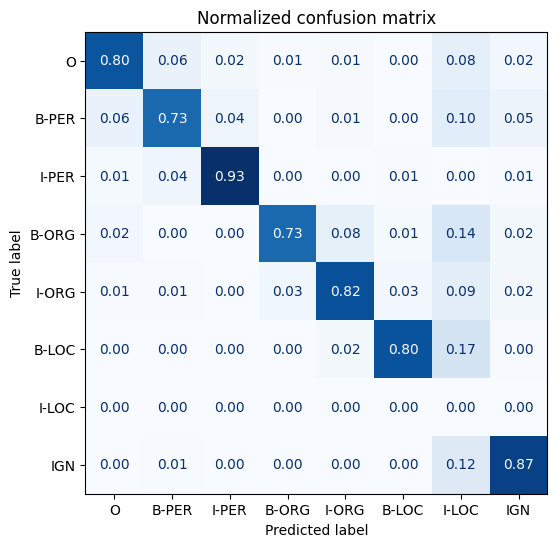

In [115]:
plot_confusion_matrix(
    df_tokens["labels"],
    df_tokens["predicted_label"],
    list(index2tag.values())
    )

* `B-ORG` is confused with `I-LOC` and `I-ORG`
* All B tags are confuses wit I tags to a minimal level